In [30]:
import cv2 as cv
import face_recognition
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os

face_cascade = cv.CascadeClassifier('image_set/haarcascade_frontalface_default.xml')

In [18]:
def take_pictures():
    cap = cv.VideoCapture(0)
    count = 1
    while True:
        ret, frame = cap.read()
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        if cv.waitKey(1) & 0xFF == ord('w'):    
            faces = face_recognition.face_locations(frame)  
            print(len(faces))
            if(len(faces) == 1):
                top, right, bottom, left = faces[0]
                face = frame[top:bottom, left:right]
                cv.imwrite("tori_" + str(count) + ".jpg", face)
                count += 1
        cv.imshow('frame', frame)
        if cv.waitKey(100) & 0xFF == ord('q'):
            break
        elif count >= 100:
            break
    cap.release()
    cv.destroyAllWindows()

In [19]:
take_pictures()
cv.destroyAllWindows()

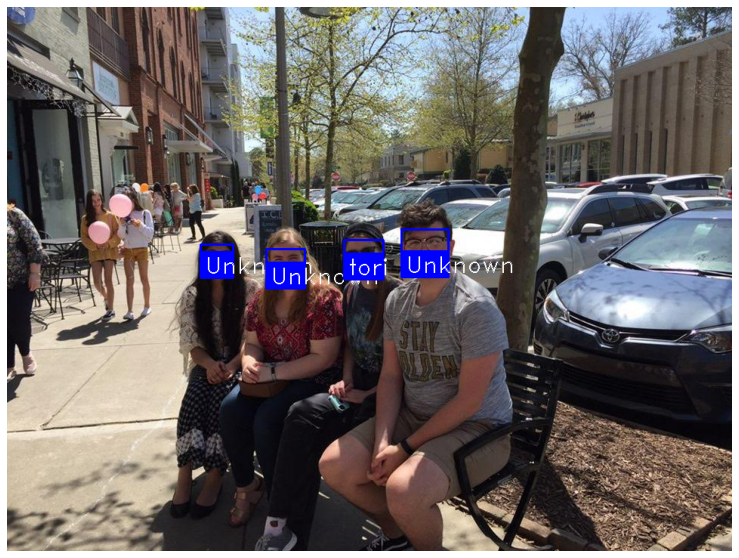

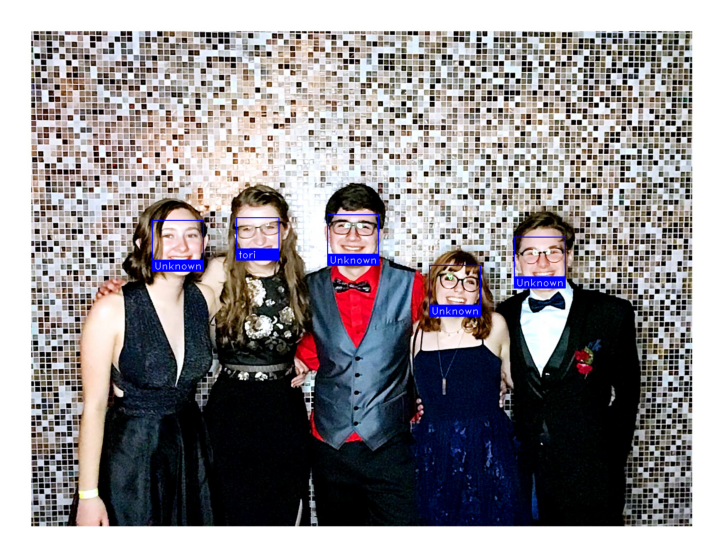

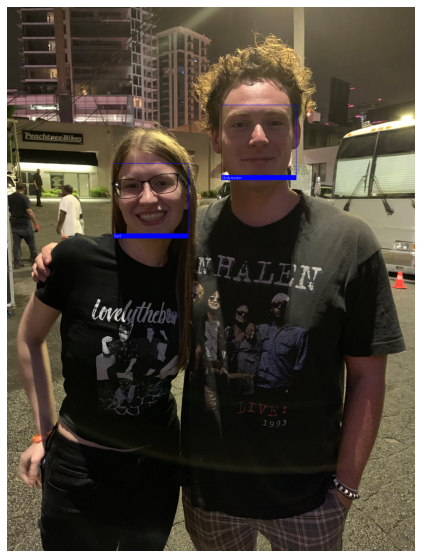

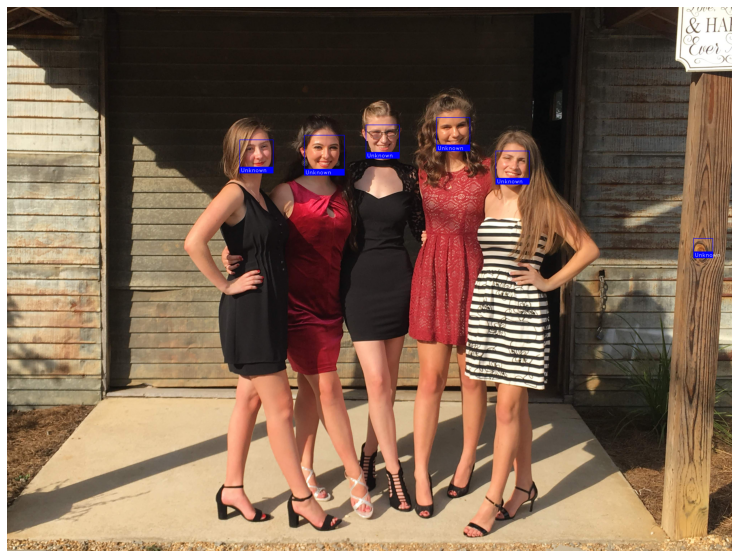

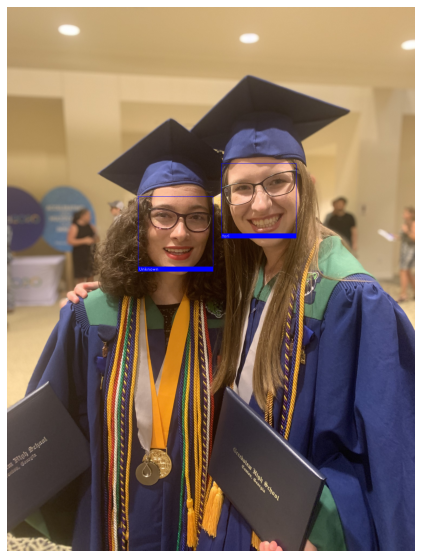

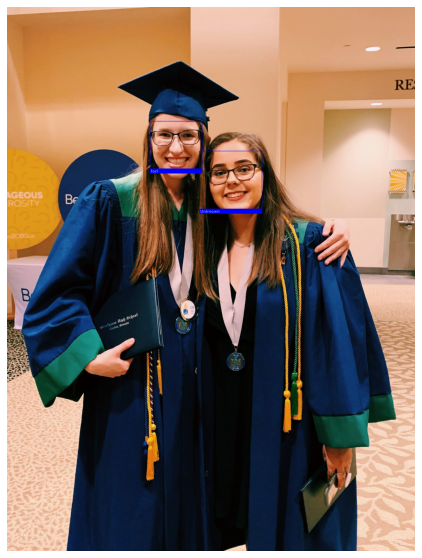

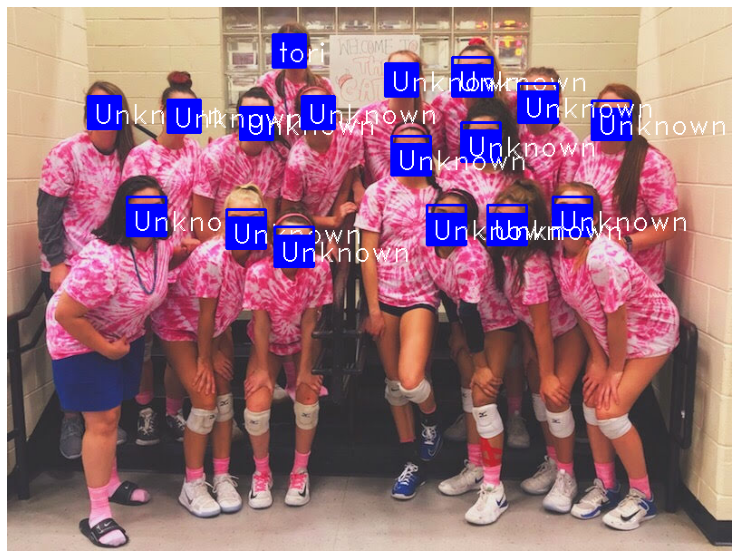

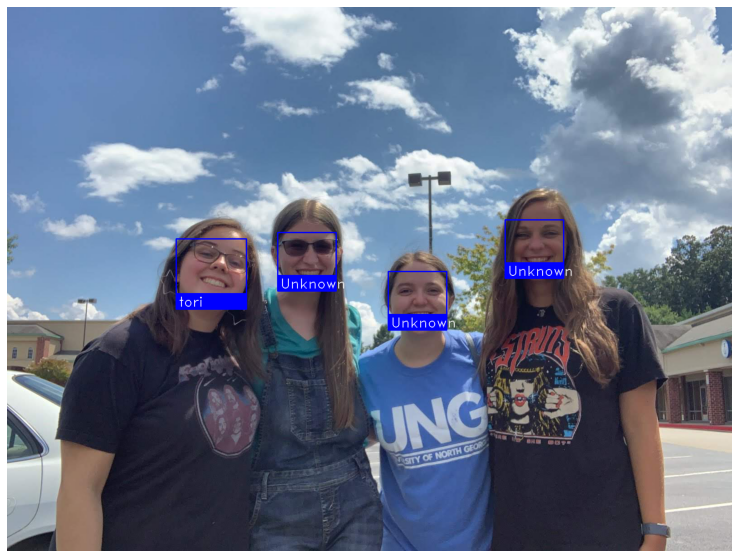

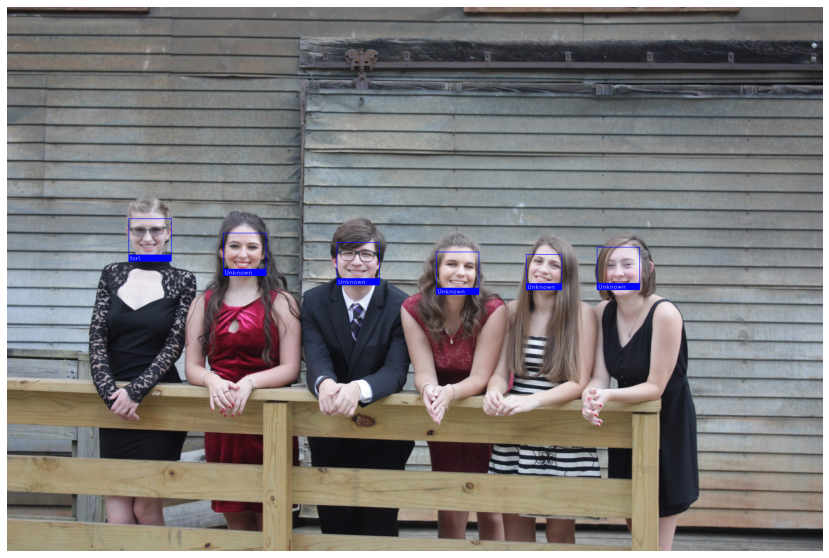

In [31]:
# load the reference training image for the one-shot learner
tori_path = './tori_1.jpg'
tori_img = face_recognition.load_image_file(tori_path)
# Get the face encodingss in the reference image
tori_face_encoding = face_recognition.face_encodings(tori_img)[0]
# Create a list of all known face encodings
known_face_encodings = [tori_face_encoding]
# Create a list of all the names
known_face_names = ['tori']
# save face_locations, face_encodings, face_names
face_locations = []
face_encodings = []
face_names = []
# Create lists for the predicted bboxes and gt_bboxes
prediction_bbox = []
gt_bbox = []
# the faces_images are present here
test_images = os.listdir('./face_imgs_tori')
# for every image in the test_images
for test_image in test_images:
    # load the image
    test_image_path = os.path.join('./face_imgs_tori', test_image)
    # load the ground truth directory
    test_img_gt = os.path.join('./face_gt/', test_image.split('.')[0]+'.txt')
    #open the ground truth text file and append the values to the ground truth list
    with open(test_img_gt, 'r') as f:
        for line in f:
            line = line.split(',')
            gt_bbox.append((int(line[0]), int(line[1]), int(line[2]), int(line[3])))
    # load the image
    test_img = face_recognition.load_image_file(test_image_path)
    # get the face locations
    face_locations = face_recognition.face_locations(test_img)
    # get the face encodings
    face_encodings = face_recognition.face_encodings(test_img, face_locations)
    # for every face encoding
    face_names = []
    for face_encoding in face_encodings:
        # See if the face is a match for the known face(s)
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = 'Unknown'
        if True in matches:
            # get the index of the first match
            first_match_index = matches.index(True)
            name = known_face_names[first_match_index]
        face_names.append(name)
    pred = None
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        # if name is predicted correctly then get the bbox locations
        if name == 'tori':
            pred = (left, top, right, bottom)
            prediction_bbox.append(pred)
        cv.rectangle(test_img, (left, top), (right, bottom), (0, 0, 255), 2)
        cv.rectangle(test_img, (left, bottom - 35), (right, bottom), (0, 0, 255), cv.FILLED)
        font = cv.FONT_HERSHEY_DUPLEX
        cv.putText(test_img, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
    if pred is None:
        prediction_bbox.append((0, 0, 1, 1))
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.imshow(test_img)
    plt.axis('off')
    plt.show()

In [32]:
# printing ground truth and bounding boxes
print(gt_bbox)
print(prediction_bbox)

[(448, 308, 501, 362), (696, 640, 826, 769), (786, 1156, 1340, 1715), (620, 2007, 829, 2174), (1590, 1156, 2141, 1715), (1059, 847, 1446, 1233), (292, 29, 327, 65), (477, 600, 628, 733), (636, 1107, 859, 1330)]
[(446, 308, 498, 360), (698, 641, 827, 770), (788, 1158, 1342, 1713), (0, 0, 1, 1), (1589, 1158, 2143, 1713), (1060, 846, 1445, 1232), (293, 30, 329, 66), (373, 511, 528, 666), (637, 1108, 860, 1331)]


In [33]:
# calculate the IoU
def get_iou(bb1, bb2):
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [34]:
# saves all the accuracies and precision and recall and IoU with their corresponding averages over the frames
accs=[]
pres=[]
recs=[]
ious = []
for i in range(len(gt_bbox)):
    print(i)
    iou = get_iou(gt_bbox[i], prediction_bbox[i])
    if iou>0.7:
        acc = 1
        pre = 1
        rec = 1
        print(f'Accuracy = {acc}')
        print(f'Precision = {pre}')
        print(f'Recall = {rec}')
        print(f'IoU = {iou}')
        accs.append(acc)
        pres.append(pre)
        recs.append(rec)
        ious.append(iou)
    elif iou<0.6:
        acc = 0
        pre = 0
        rec = 0
        print(f'Accuracy = {acc}')
        print(f'Precision = {pre}')
        print(f'Recall = {rec}')
        print(f'IoU = {iou}')
        accs.append(acc)
        pres.append(pre)
        recs.append(rec)
        ious.append(iou)
print("Average Accuracy = ", sum(accs)/len(accs))
print("Average Precision = ", sum(pres)/len(pres))
print("Average Recall = ", sum(recs)/len(recs))
print("Average IoU = ", sum(ious)/len(ious))

0
Accuracy = 1
Precision = 1
Recall = 1
IoU = 0.8766014834794336
1
Accuracy = 1
Precision = 1
Recall = 1
IoU = 0.9622364479943619
2
Accuracy = 1
Precision = 1
Recall = 1
IoU = 0.9857269720331021
3
Accuracy = 0
Precision = 0
Recall = 0
IoU = 0.0
4
Accuracy = 1
Precision = 1
Recall = 1
IoU = 0.9875062162144707
5
Accuracy = 1
Precision = 1
Recall = 1
IoU = 0.9897040068907036
6
Accuracy = 1
Precision = 1
Recall = 1
IoU = 0.8711566617862372
7
Accuracy = 0
Precision = 0
Recall = 0
IoU = 0.08261744636983948
8
Accuracy = 1
Precision = 1
Recall = 1
IoU = 0.9822617291824451
Average Accuracy =  0.7777777777777778
Average Precision =  0.7777777777777778
Average Recall =  0.7777777777777778
Average IoU =  0.748645662661177
